In [1]:
import music21
from music21 import converter, instrument, note, chord, midi, stream
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


# Parameters
Here are parameters you can edit in this script.

In [2]:
# Memory length -- each new note is generated by considering this many previous notes
sequence_length = 20

# How many rounds of training to perform -- more training will likely provide better performance
training_rounds = 20

# Where to ouput the generated file
output_file = "output.mid"

# Number of output notes to generate
numberOutputNotes = 200

# Save model checkpoints
saveModel = False


### Preprocessing
First we must load the data from the songs. To do this, we'll go through all the songs in our training data of MIDI files. We parse them with music21 to get the individual notes. If the element is a chord, then it is converted to it's numerical representation. After this step we will have all of the notes/chords that appear in string form, and a corresponding vocabulary as a set of them all.

In [3]:
notes = []
track = 0

files = glob.glob("input*.mid")

for i, file in enumerate(files):
    midi = converter.parse(file)
    # There are multiple tracks in the MIDI file, so we'll use the first one
    midi = midi[track]
    notes_to_parse = None
        
    # Parse the midi file by the notes it contains
    notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:
        if isinstance(element, music21.note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            # get's the normal order (numerical representation) of the chord
            notes.append('.'.join(str(n) for n in element.normalOrder))
    print("Song {} Loaded".format(i+1))
                
print("DONE LOADING SONGS")    
# Get all pitch names
pitches = sorted(set(item for item in notes))
# Get all pitch names
vocab_length = len(pitches)  
number_notes = len(notes)
# print(vocab_length)
# print(notes)
# print(len(notes))
print(f'I found {number_notes} notes')


Song 1 Loaded
Song 2 Loaded
DONE LOADING SONGS
I found 3098 notes


In [4]:
assert len(notes) > sequence_length

Now we must get these notes in a usable form for our LSTM. Let's construct sequences that can be grouped together to predict the next note in groups of 10 notes.

In [5]:
# Let's use One Hot Encoding for each of the notes and create an array as such of sequences. 
#Let's first assign an index to each of the possible notes
note_dict = dict()
for i, note in enumerate(pitches):
    note_dict[note] = i
#print(note_dict)



# Lets make a numpy array with the number of training examples, sequence length, and the length of the one-hot-encoding
num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    # Here, i is the training example, j is the note in the sequence for a specific training example
    input_sequence = notes[i: i+sequence_length]
    output_note = notes[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [8]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

if saveModel:
    filepath="weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(input_notes, output_notes, batch_size=128, nb_epoch=training_rounds, callbacks=callbacks_list)
else:
    history = model.fit(input_notes, output_notes, batch_size=128, nb_epoch=training_rounds)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/300
2898/2898 [==============================] - 22s 8ms/step - loss: 4.5096 - acc: 0.0404

Epoch 00001: acc improved from -inf to 0.04037, saving model to weights-improvement-01-0.04.hdf5
Epoch 2/300
2898/2898 [==============================] - 20s 7ms/step - loss: 4.2462 - acc: 0.0480

Epoch 00002: acc improved from 0.04037 to 0.04796, saving model to weights-improvement-02-0.05.hdf5
Epoch 3/300
2898/2898 [==============================] - 21s 7ms/step - loss: 4.1558 - acc: 0.0566

Epoch 00003: acc improved from 0.04796 to 0.05659, saving model to weights-improvement-03-0.06.hdf5
Epoch 4/300
2898/2898 [==============================] - 20s 7ms/step - loss: 4.0597 - acc: 0.0659

Epoch 00004: acc improved from 0.05659 to 0.06591, saving model to weights-improvement-04-0.07.hdf5
Epoch 5/300
2898/2898 [==============================] - 21s 7ms/step - loss: 3.9234 - acc: 0.0759

Epoch 00005: acc improved from 0.06591 to 0.07591, saving model to weights-improvement-05-0.08.hdf5
Epo

2898/2898 [==============================] - 25s 9ms/step - loss: 2.2585 - acc: 0.2723

Epoch 00046: acc improved from 0.25880 to 0.27226, saving model to weights-improvement-46-0.27.hdf5
Epoch 47/300
2898/2898 [==============================] - 23s 8ms/step - loss: 2.2631 - acc: 0.2692

Epoch 00047: acc did not improve from 0.27226
Epoch 48/300
2898/2898 [==============================] - 23s 8ms/step - loss: 2.2414 - acc: 0.2702

Epoch 00048: acc did not improve from 0.27226
Epoch 49/300
2898/2898 [==============================] - 25s 9ms/step - loss: 2.2359 - acc: 0.2640

Epoch 00049: acc did not improve from 0.27226
Epoch 50/300
2898/2898 [==============================] - 24s 8ms/step - loss: 2.1941 - acc: 0.2823

Epoch 00050: acc improved from 0.27226 to 0.28226, saving model to weights-improvement-50-0.28.hdf5
Epoch 51/300
2898/2898 [==============================] - 23s 8ms/step - loss: 2.2079 - acc: 0.2736

Epoch 00051: acc did not improve from 0.28226
Epoch 52/300
2898/2898 

2898/2898 [==============================] - 23s 8ms/step - loss: 1.6576 - acc: 0.3989

Epoch 00094: acc improved from 0.39855 to 0.39890, saving model to weights-improvement-94-0.40.hdf5
Epoch 95/300
2898/2898 [==============================] - 22s 8ms/step - loss: 1.6929 - acc: 0.4023

Epoch 00095: acc improved from 0.39890 to 0.40235, saving model to weights-improvement-95-0.40.hdf5
Epoch 96/300
2898/2898 [==============================] - 22s 8ms/step - loss: 1.6301 - acc: 0.4041

Epoch 00096: acc improved from 0.40235 to 0.40407, saving model to weights-improvement-96-0.40.hdf5
Epoch 97/300
2898/2898 [==============================] - 24s 8ms/step - loss: 1.6354 - acc: 0.3992

Epoch 00097: acc did not improve from 0.40407
Epoch 98/300
2898/2898 [==============================] - 22s 8ms/step - loss: 1.6100 - acc: 0.4155

Epoch 00098: acc improved from 0.40407 to 0.41546, saving model to weights-improvement-98-0.42.hdf5
Epoch 99/300
2898/2898 [==============================] - 23s 

2898/2898 [==============================] - 22s 8ms/step - loss: 1.2401 - acc: 0.5428

Epoch 00141: acc did not improve from 0.55280
Epoch 142/300
2898/2898 [==============================] - 22s 8ms/step - loss: 1.2301 - acc: 0.5338

Epoch 00142: acc did not improve from 0.55280
Epoch 143/300
2898/2898 [==============================] - 22s 7ms/step - loss: 1.2308 - acc: 0.5469

Epoch 00143: acc did not improve from 0.55280
Epoch 144/300
2898/2898 [==============================] - 23s 8ms/step - loss: 1.2186 - acc: 0.5497

Epoch 00144: acc did not improve from 0.55280
Epoch 145/300
2898/2898 [==============================] - 22s 8ms/step - loss: 1.2083 - acc: 0.5645

Epoch 00145: acc improved from 0.55280 to 0.56453, saving model to weights-improvement-145-0.56.hdf5
Epoch 146/300
2898/2898 [==============================] - 22s 8ms/step - loss: 1.1665 - acc: 0.5652

Epoch 00146: acc improved from 0.56453 to 0.56522, saving model to weights-improvement-146-0.57.hdf5
Epoch 147/300
28

2898/2898 [==============================] - 22s 8ms/step - loss: 0.8544 - acc: 0.6957

Epoch 00188: acc did not improve from 0.70359
Epoch 189/300
2898/2898 [==============================] - 23s 8ms/step - loss: 0.8477 - acc: 0.7026

Epoch 00189: acc did not improve from 0.70359
Epoch 190/300
2898/2898 [==============================] - 26s 9ms/step - loss: 0.8503 - acc: 0.6991

Epoch 00190: acc did not improve from 0.70359
Epoch 191/300
2898/2898 [==============================] - 25s 9ms/step - loss: 0.8425 - acc: 0.7133

Epoch 00191: acc improved from 0.70359 to 0.71325, saving model to weights-improvement-191-0.71.hdf5
Epoch 192/300
2898/2898 [==============================] - 24s 8ms/step - loss: 0.8346 - acc: 0.7115

Epoch 00192: acc did not improve from 0.71325
Epoch 193/300
2898/2898 [==============================] - 23s 8ms/step - loss: 0.8209 - acc: 0.7101

Epoch 00193: acc did not improve from 0.71325
Epoch 194/300
2898/2898 [==============================] - 22s 8ms/step

2898/2898 [==============================] - 22s 8ms/step - loss: 0.5600 - acc: 0.8199

Epoch 00234: acc did not improve from 0.82298
Epoch 235/300
2898/2898 [==============================] - 22s 8ms/step - loss: 0.5412 - acc: 0.8347

Epoch 00235: acc improved from 0.82298 to 0.83471, saving model to weights-improvement-235-0.83.hdf5
Epoch 236/300
2898/2898 [==============================] - 22s 8ms/step - loss: 0.5437 - acc: 0.8244

Epoch 00236: acc did not improve from 0.83471
Epoch 237/300
2898/2898 [==============================] - 24s 8ms/step - loss: 0.5313 - acc: 0.8264

Epoch 00237: acc did not improve from 0.83471
Epoch 238/300
2898/2898 [==============================] - 23s 8ms/step - loss: 0.5317 - acc: 0.8285

Epoch 00238: acc did not improve from 0.83471
Epoch 239/300
2898/2898 [==============================] - 24s 8ms/step - loss: 0.5277 - acc: 0.8347

Epoch 00239: acc did not improve from 0.83471
Epoch 240/300
2898/2898 [==============================] - 22s 7ms/step

2898/2898 [==============================] - 22s 7ms/step - loss: 0.3261 - acc: 0.9113

Epoch 00283: acc did not improve from 0.91166
Epoch 284/300
2898/2898 [==============================] - 21s 7ms/step - loss: 0.3073 - acc: 0.9179

Epoch 00284: acc improved from 0.91166 to 0.91787, saving model to weights-improvement-284-0.92.hdf5
Epoch 285/300
2898/2898 [==============================] - 21s 7ms/step - loss: 0.3120 - acc: 0.9117

Epoch 00285: acc did not improve from 0.91787
Epoch 286/300
2898/2898 [==============================] - 21s 7ms/step - loss: 0.3035 - acc: 0.9199

Epoch 00286: acc improved from 0.91787 to 0.91994, saving model to weights-improvement-286-0.92.hdf5
Epoch 287/300
2898/2898 [==============================] - 21s 7ms/step - loss: 0.3110 - acc: 0.9103

Epoch 00287: acc did not improve from 0.91994
Epoch 288/300
2898/2898 [==============================] - 21s 7ms/step - loss: 0.4734 - acc: 0.8854

Epoch 00288: acc did not improve from 0.91994
Epoch 289/300
28

#### Visualizing the Model's Results
The models accuracy can be seen here increasing, as it learns the sequences over the course of 200 epochs.

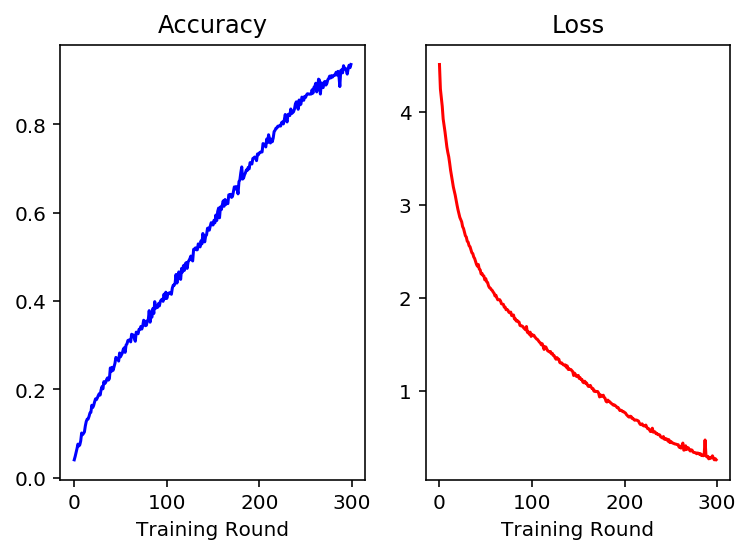

In [9]:
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'], color='b')
plt.title('Accuracy')
plt.xlabel('Training Round')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='r')
plt.title("Loss")
plt.xlabel('Training Round')
plt.show()

### Generating New Music

In [12]:
# Make a dictionary going backwards (with index as key and the note as the value)
backward_dict = dict()
for note in note_dict.keys():
    index = note_dict[note]
    backward_dict[index] = note

# pick a random sequence from the input as a starting point for the prediction
n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []


# Generate song with numberOutputNotes notes
for i in range(0, numberOutputNotes):
    newNote = model.predict(start_sequence, verbose=0)
    # Get the position with the highest probability
    index = np.argmax(newNote)
    encoded_note = np.zeros((vocab_length))
    encoded_note[index] = 1
    output.append(encoded_note)
    sequence = start_sequence[0][1:]
    start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
    start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)
    

# Now output is populated with notes in their string form
# for element in output:
#    print(element)

### Convert to MIDI format
Code here to output to MIDI files taken from github repo https://github.com/Skuldur/Classical-Piano-Composer.

In [14]:
finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []
    
# create note and chord objects based on the values generated by the model
for pattern in finalNotes:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp=output_file)
print(f"Done writing output file: {output_file}")

Done writing output file: output.mid
